In [1]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get dataset
reviews = pd.read_csv("../data/gojek_reviews.csv")
reviews.head()

,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,Forgot my airport in his car and I didn't rece...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,So far so good,0,2025-02-23 14:04:35,NaN,NaN,5.10.1,5.10.1
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,NaN,NaN,5.11.1,5.11.1
3,451872f2-472a-4696-a6f9-cb5ed515c6b6,arfandi amiruddin,5,Good,0,2025-02-23 12:46:18,NaN,NaN,5.11.1,5.11.1
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,"The ""play later"" Promo is annoying. Can't use ...",1,2025-02-23 12:32:42,NaN,NaN,4.32.1,4.32.1


# 1. Explore the dataset

### a. Analyze the distribution of review lengths

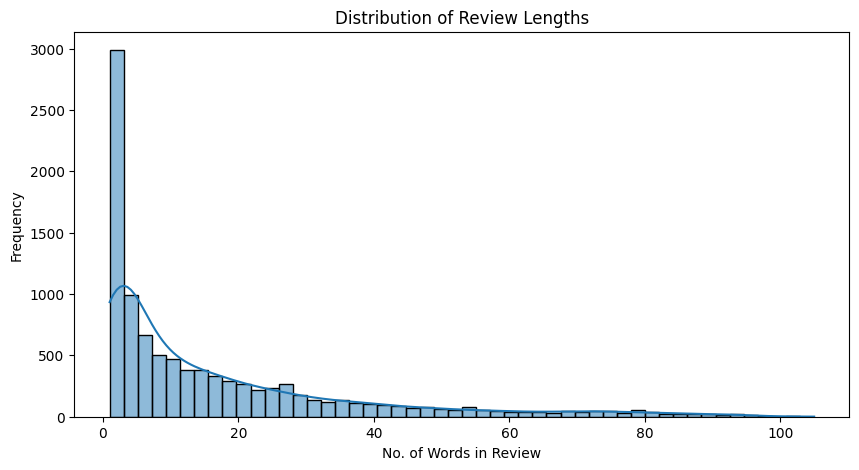

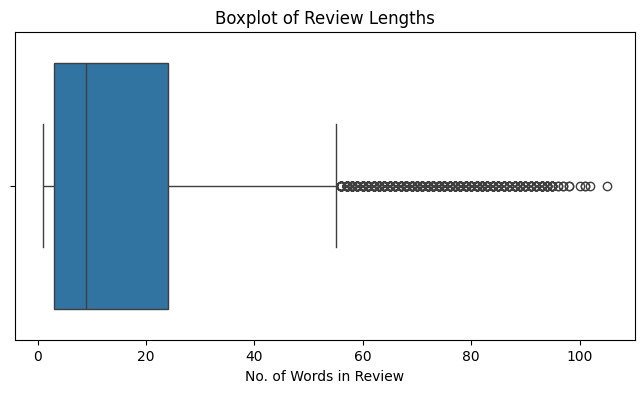

In [2]:
# Add a column for word count
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))

# Histogram to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.xlabel("No. of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=reviews['word_count'])
plt.xlabel("No. of Words in Review")
plt.title("Boxplot of Review Lengths")
plt.show()

The histogram shows a strong right-skewed distribution, meaning most reviews are very short, but the boxplot tells us that there are also many outliers (long reviews).

### b. Identify common words and phrases used in reviews

/tmp/ipykernel_424086/593663789.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


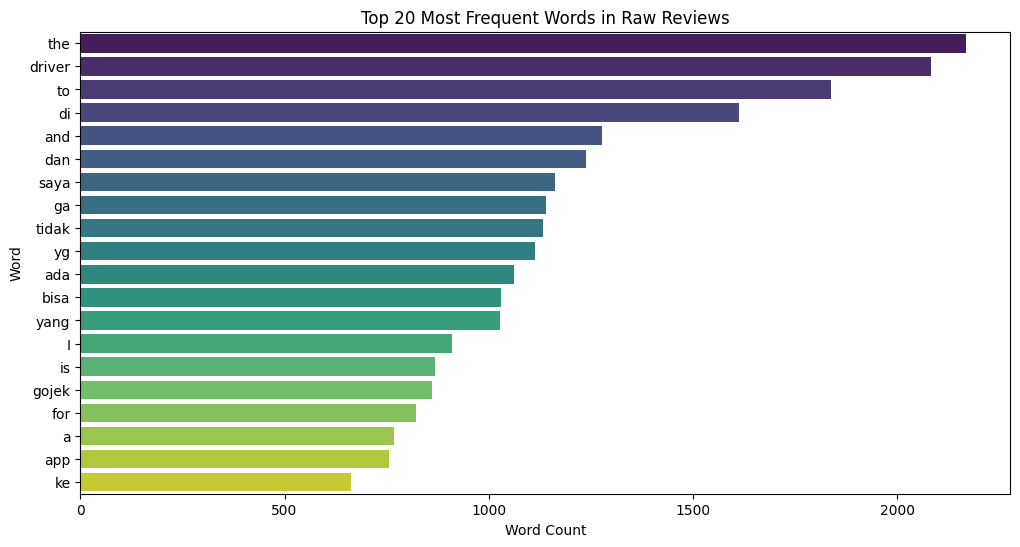

In [3]:
from collections import Counter

# Join all reviews into one string
all_words = ' '.join(reviews['content'].astype(str)).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20
most_common_words = word_freq.most_common(20)

# Seperate the words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Raw Reviews")
plt.show()

# 2. Clean and preprocess text data

### a. Convert text to lowercase

In [4]:
# Convert review content to lowercase
reviews['content'] = reviews['content'].str.lower()

### b. Remove stop words, punctuation, and special characters

In [5]:
# Remove punctuation and special characters
import re
reviews['content'] = reviews['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else x)

# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english')) 

# Load Indonesian stopwords
id_stopwords_path = "../data/id_stopwords.txt"
id_stopwords = set()

with open(id_stopwords_path, 'r') as file:
    for line in file:
        id_stopwords.add(line.strip())

# Combine English & Indonesian stopwords
all_stopwords = english_stopwords.union(id_stopwords)

def remove_stopwords(text):
    if isinstance(text,str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stopwords]
        return ' '.join(filtered_words)
    return text

reviews['content'] = reviews['content'].apply(remove_stopwords)
reviews.dropna(subset=['content'], inplace=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### c. Tokenization and stemming/lemmatization

In [6]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

reviews['lemmatized_content'] = reviews['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


d. Filter rare words

In [7]:
from collections import Counter

# Count word frequencies
all_words = ' '.join(reviews['lemmatized_content']).split()
word_freq = Counter(all_words)

# Identify words that appear at least 1 times
min_freq = 2
valid_words = set([word for word, freq in word_freq.items() if freq >= min_freq])

# Filter each review to remove rare words and numerics
def filter_rare_words(text):
    return ' '.join([
        word for word in text.split() 
        if word in valid_words and not word.isnumeric()
        ])

# Apply to lemmatized content
reviews['lemmatized_content'] = reviews['lemmatized_content'].apply(filter_rare_words)


### d. Handle duplicate or noisy data

In [8]:
# Handle duplicate and noisy data
print(f"Original dataset shape: {reviews.shape}")

# Check and remove duplicates
duplicate_count = reviews.duplicated(subset=['lemmatized_content']).sum()
print(f"Found {duplicate_count} duplicate reviews")
reviews = reviews.drop_duplicates(subset=['lemmatized_content'])

# Remove very short reviews (likely noise)
reviews['word_count'] = reviews['lemmatized_content'].apply(lambda x: len(str(x).split()))
short_reviews = reviews[reviews['word_count'] < 2].shape[0]
print(f"Removing {short_reviews} very short reviews (less than 2 words)")
reviews = reviews[reviews['word_count'] >= 2]

# Handle missing values in any other columns
missing_values = reviews.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Fill missing numerical values with median (if any)
numerical_cols = reviews.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].median())

# Fill missing categorical/text values with mode (if any)
categorical_cols = reviews.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'content' and col != 'lemmatized_content' and reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].mode()[0])

# Check for outliers in rating (if present)
if 'rating' in reviews.columns:
    print("\nRating distribution:")
    print(reviews['rating'].value_counts())
    
    # Check if there are invalid ratings outside expected range (e.g., 1-5)
    invalid_ratings = reviews[(reviews['rating'] < 1) | (reviews['rating'] > 5)].shape[0]
    if invalid_ratings > 0:
        print(f"Found {invalid_ratings} reviews with invalid ratings")
        # Remove or fix invalid ratings
        reviews = reviews[(reviews['rating'] >= 1) & (reviews['rating'] <= 5)]

print(f"\nCleaned dataset shape: {reviews.shape}")
reviews.head()

Original dataset shape: (10000, 12)
Found 2105 duplicate reviews
Removing 332 very short reviews (less than 2 words)

Missing values in each column:
reviewId                   0
userName                   2
score                      0
content                    0
thumbsUpCount              0
at                         0
replyContent            2937
repliedAt               2937
reviewCreatedVersion    1141
appVersion              1141
word_count                 0
lemmatized_content         0
dtype: int64

Cleaned dataset shape: (7563, 12)


,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion,word_count,lemmatized_content
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,forgot airport car didnt receive infofollow dr...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1,8,forgot airport car didnt receive driver also apps
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,far good,0,2025-02-23 14:04:35,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.10.1,5.10.1,2,far good
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.11.1,5.11.1,3,drivernya cakep hehe
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,play later promo annoying cant use anw u keep ...,1,2025-02-23 12:32:42,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,4.32.1,4.32.1,10,play later promo annoying cant use u keep disp...
5,ac4fed4e-7bf4-4677-b973-98f4d3c9df0f,Husen Badrutamam,1,jelek banget kelakuan drivernya yg ambil order...,0,2025-02-23 10:36:21,"Hai Kak Husen, mohon maaf atas ketidaknyamanan...",2025-02-23 11:01:14,5.10.1,5.10.1,17,jelek banget kelakuan drivernya yg ambil order...


In [9]:
# --- Tokenization and Vectorization Methods for Topic Modeling ---

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
import numpy as np

# Prepare documents
documents = reviews['lemmatized_content'].astype(str).tolist()
tokenized_docs = [doc.split() for doc in documents]

# 1. Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(documents)
bow_feature_names = count_vectorizer.get_feature_names_out()

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 3. Word2Vec
w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=2, workers=4)
# For each document, get the mean vector (if empty, use zeros)
X_w2v = np.array([
    np.mean([w2v_model.wv[word] for word in doc if word in w2v_model.wv] or [np.zeros(100)], axis=0)
    for doc in tokenized_docs
])

# Tokenization and Vectorization Setup
documents_raw = reviews['lemmatized_content'].astype(str).tolist()
tokenization_methods = {
    "simple_tokenization": [doc.split() for doc in documents_raw],
    "word_tokenization": [word_tokenize(doc) for doc in documents_raw]
}
vectorizers = {
    "bow": CountVectorizer(max_df=0.95, min_df=2, stop_words='english'),
    "tfidf": TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
}

# Coherence helper
def compute_coherence(topics, tokens, id2word):
    return CoherenceModel(topics=topics, texts=tokens, dictionary=id2word, coherence="c_v").get_coherence()


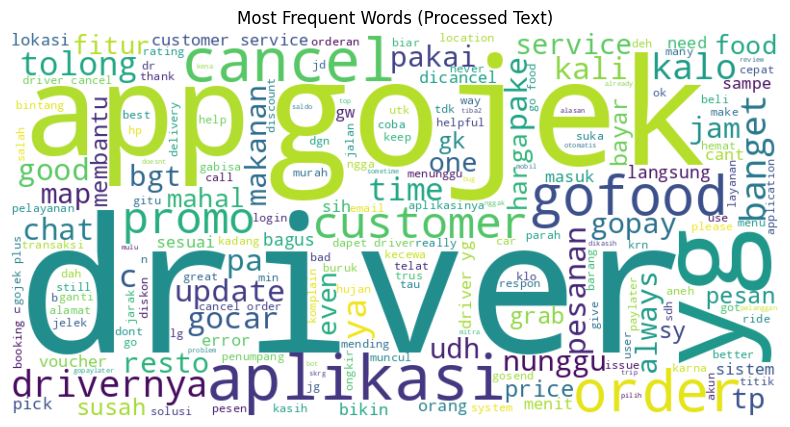

In [10]:
from wordcloud import WordCloud

processed_words = ' '.join(reviews['lemmatized_content'].astype(str))
wordcloud = WordCloud(width=800, height=400, 
                     background_color="white",
                     max_words=200).generate(processed_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words (Processed Text)")
plt.show()

# 3. Topic Modelling

### a. Use algorithms to identify key topics

#### Using Latent Dirichlet Allocation (LDA)

In [11]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

lda_results = []

for token_name, tokens in tokenization_methods.items():
    id2word = Dictionary(tokens)
    id2word.filter_extremes(no_below=3, no_above=0.9)
    corpus_bow = [id2word.doc2bow(text) for text in tokens]

    for vec_name, vectorizer in vectorizers.items():
        corpus = corpus_bow
        if vec_name == "tfidf":
            tfidf_model = TfidfModel(corpus_bow)
            corpus = tfidf_model[corpus_bow]

        lda_model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=7,
            random_state=42,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=tokens,
            dictionary=id2word,
            coherence="c_v"
        )
        coherence = coherence_model.get_coherence()

        print(f"LDA | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")
        lda_results.append({
            "tokenization": token_name,
            "vectorization": vec_name,
            "coherence": coherence,
            "model": lda_model
        })

# Best LDA result
best_lda = max(lda_results, key=lambda x: x["coherence"])
print(f"\nBest LDA Result:\nTokenization: {best_lda['tokenization']}, Vectorization: {best_lda['vectorization']}, Coherence: {best_lda['coherence']:.4f}")

# Top topics for best model
print("Top topics:")
for topic in best_lda["model"].print_topics():
    print(topic)


LDA | Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.5399
LDA | Tokenization: simple_tokenization, Vectorization: tfidf, Coherence: 0.5965
LDA | Tokenization: word_tokenization, Vectorization: bow, Coherence: 0.5203
LDA | Tokenization: word_tokenization, Vectorization: tfidf, Coherence: 0.5260

Best LDA Result:
Tokenization: simple_tokenization, Vectorization: tfidf, Coherence: 0.5965
Top topics:
(0, '0.010*"langganan" + 0.010*"helpfull" + 0.008*"payah" + 0.008*"excellent" + 0.007*"otomatis" + 0.006*"server" + 0.006*"saldo" + 0.006*"isi" + 0.006*"topup" + 0.005*"banyakin"')
(1, '0.016*"app" + 0.012*"time" + 0.008*"cant" + 0.008*"use" + 0.008*"ride" + 0.008*"always" + 0.008*"even" + 0.007*"good" + 0.007*"better" + 0.007*"keep"')
(2, '0.025*"good" + 0.019*"service" + 0.016*"nice" + 0.016*"best" + 0.013*"great" + 0.013*"far" + 0.012*"ok" + 0.010*"bad" + 0.010*"app" + 0.008*"application"')
(3, '0.027*"easy" + 0.016*"helpful" + 0.015*"useful" + 0.012*"good" + 0.012*"lif

### Using Non-Negative Matrix Factorization (NMF)

In [12]:
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
import os

nmf_results = []

for token_name, tokenized in tokenization_methods.items():
    docs_as_text = [' '.join(doc) for doc in tokenized]
    id2word = Dictionary(tokenized)
    id2word.filter_extremes(no_below=3, no_above=0.9)

    for vec_name, vectorizer in vectorizers.items():
        X = vectorizer.fit_transform(docs_as_text)
        feature_names = vectorizer.get_feature_names_out()

        nmf_model = NMF(n_components=7, random_state=42, max_iter=500)
        nmf_H = nmf_model.fit_transform(X)
        topics = [[feature_names[i] for i in comp.argsort()[:-11:-1]] for comp in nmf_model.components_]

        docs_for_coherence = [doc.split() for doc in docs_as_text]
        id2word = Dictionary(docs_for_coherence)
        coherence = compute_coherence(topics, docs_for_coherence, id2word)

        print(f"NMF | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")

        nmf_results.append({
            "tokenization": token_name,
            "vectorization": vec_name,
            "topics": topics,
            "coherence": coherence
        })

# Best NMF result
best_nmf = max(nmf_results, key=lambda x: x["coherence"])
print(f"\nBest NMF Result:\nTokenization: {best_nmf['tokenization']}, Vectorization: {best_nmf['vectorization']}, Coherence: {best_nmf['coherence']:.4f}")
print("Top topics:")
for i, topic in enumerate(best_nmf["topics"]):
    print(f"Topic {i+1}: {' + '.join(topic)}")


NMF | Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.6362
NMF | Tokenization: simple_tokenization, Vectorization: tfidf, Coherence: 0.5146
NMF | Tokenization: word_tokenization, Vectorization: bow, Coherence: 0.6362
NMF | Tokenization: word_tokenization, Vectorization: tfidf, Coherence: 0.5146

Best NMF Result:
Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.6362
Top topics:
Topic 1: driver + customer + rating + gocar + dapet + time + pick + penumpang + susah + tip
Topic 2: gojek + plus + akun + pakai + pake + customer + ya + tolong + promo + gopay
Topic 3: app + time + service + use + good + customer + dont + food + bad + need
Topic 4: order + food + time + hour + restaurant + delivery + gofood + gocar + cancelled + cancel
Topic 5: yg + promo + gocar + pake + drivernya + sy + tp + titik + tolong + harga
Topic 6: aplikasi + gopay + pakai + customer + banget + chat + pake + saldo + bayar + pesanan
Topic 7: cancel + gofood + nunggu + jam + resto +

#### Using BERTopics

In [13]:
# from bertopic import BERTopic
# from gensim.corpora import Dictionary
# import os

# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# bertopic_results = []

# for token_name, tokenized in tokenization_methods.items():
#     docs_as_text = [' '.join(doc) for doc in tokenized]
#     id2word = Dictionary(tokenized)
#     id2word.filter_extremes(no_below=3, no_above=0.9)

#     for vec_name, vectorizer in vectorizers.items():
#         bertopic_model = BERTopic(
#             language="multilingual",
#             vectorizer_model=vectorizer,
#             calculate_probabilities=True,
#             verbose=False
#         )

#         topics, probs = bertopic_model.fit_transform(docs_as_text)
#         bertopic_model.reduce_topics(docs_as_text, nr_topics=7)

#         topic_words = []
#         for i in range(7):
#             topic = bertopic_model.get_topic(i)
#             if topic:  # non-empty
#                 topic_words.append([word for word, _ in topic])

#         if topic_words:
#             coherence = compute_coherence(topic_words, tokenized, id2word)
#             print(f"BERTopic | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")
#         else:
#             coherence = 0
#             print(f"BERTopic | Tokenization: {token_name}, Vectorization: {vec_name}, No topics")

#         bertopic_results.append({
#             "tokenization": token_name,
#             "vectorization": vec_name,
#             "topics": topic_words,
#             "coherence": coherence
#         })

# # Best BERTopic result
# best_bertopic = max(bertopic_results, key=lambda x: x["coherence"])
# print(f"\nBest BERTopic Result:\nTokenization: {best_bertopic['tokenization']}, Vectorization: {best_bertopic['vectorization']}, Coherence: {best_bertopic['coherence']:.4f}")
# print("Top topics:")
# for i, topic in enumerate(best_bertopic["topics"]):
#     print(f"Topic {i+1}: {' + '.join(topic)}")


### b. Determine the optimal number of topics using coherence scores or topic coherence visualization

#### 1) By Coherence Visualization

In [14]:
# from gensim.models import CoherenceModel, LdaModel
# from sklearn.decomposition import NMF
# from bertopic import BERTopic
# from copy import deepcopy
# import matplotlib.pyplot as plt

# # Evaluate no. topics 2-10
# topic_range = range(2, 11)

# # Reuse best LDA 
# lda_tokens = tokenization_methods[best_lda['tokenization']]
# lda_id2word = Dictionary(lda_tokens)
# lda_id2word.filter_extremes(no_below=3, no_above=0.9)
# lda_corpus_bow = [lda_id2word.doc2bow(text) for text in lda_tokens]
# if best_lda['vectorization'] == 'tfidf':
#     tfidf_model = TfidfModel(lda_corpus_bow)
#     lda_corpus = tfidf_model[lda_corpus_bow]
# else:
#     lda_corpus = lda_corpus_bow

# # Reuse best NMF 
# nmf_tokens = tokenization_methods[best_nmf['tokenization']]
# nmf_docs = [' '.join(doc) for doc in nmf_tokens]
# nmf_vectorizer = vectorizers[best_nmf['vectorization']]
# nmf_X = nmf_vectorizer.fit_transform(nmf_docs)
# nmf_feature_names = nmf_vectorizer.get_feature_names_out()
# nmf_id2word = Dictionary(nmf_tokens)
# nmf_id2word.filter_extremes(no_below=3, no_above=0.9)

# # Reuse best BERTopic 
# bertopic_tokens = tokenization_methods[best_bertopic['tokenization']]
# bertopic_docs = [' '.join(doc) for doc in bertopic_tokens]
# bertopic_vectorizer = deepcopy(vectorizers[best_bertopic['vectorization']])
# bertopic_vectorizer.set_params(min_df=1, max_df=1.0)
# bertopic_id2word = Dictionary(bertopic_tokens)
# nmf_id2word.filter_extremes(no_below=3, no_above=0.9)

# # Pre-fit BERTopic model once
# # bertopic_model = BERTopic(language="multilingual", vectorizer_model=bertopic_vectorizer, verbose=False)
# # topics, _ = bertopic_model.fit_transform(bertopic_docs)

# coherence_scores_lda = []
# coherence_scores_nmf = []
# coherence_scores_bertopic = []

# for num_topics in topic_range:
#     # LDA
#     lda_model = LdaModel(
#         corpus=lda_corpus,
#         id2word=lda_id2word,
#         num_topics=num_topics,
#         random_state=42,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     cm_lda = CoherenceModel(model=lda_model, texts=lda_tokens, dictionary=lda_id2word, coherence='c_v')
#     coh_lda = cm_lda.get_coherence()
#     coherence_scores_lda.append(coh_lda)

#     # NMF
#     nmf_model = NMF(
#         n_components=num_topics, 
#         random_state=42, 
#         max_iter=500
#     )
#     nmf_W = nmf_model.fit_transform(nmf_X)
#     nmf_topics = [[nmf_feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
#     cm_nmf = CoherenceModel(topics=nmf_topics, texts=nmf_tokens, dictionary=nmf_id2word, coherence='c_v')
#     coh_nmf = cm_nmf.get_coherence()
#     coherence_scores_nmf.append(coh_nmf)

#     # BERTopic
#     bertopic_model = BERTopic(
#         language="multilingual",
#         vectorizer_model=deepcopy(bertopic_vectorizer),
#         calculate_probabilities=False,
#         verbose=False
#     )
#     topics, _ = bertopic_model.fit_transform(bertopic_docs)
#     bertopic_model.reduce_topics(bertopic_docs, nr_topics=num_topics)
#     bertopic_topics = [bertopic_model.get_topic(i) for i in range(num_topics)]
#     topic_words = [[word for word, _ in topic] for topic in bertopic_topics if topic]
#     cm_bertopic = CoherenceModel(topics=topic_words, texts=bertopic_tokens, dictionary=bertopic_id2word, coherence="c_v")
#     coh_bertopic = cm_bertopic.get_coherence()
#     coherence_scores_bertopic.append(coh_bertopic)

#     print(f"k=={num_topics} | LDA Coherence: {coh_lda:.4f} | NMF Coherence: {coh_nmf:.4f} | BERTopic Coherence: {coh_bertopic:.4f}")

# plt.figure(figsize=(10, 6))
# plt.plot(topic_range, coherence_scores_lda, marker="o", linestyle="-", label="LDA", color="blue")
# plt.plot(topic_range, coherence_scores_nmf, marker="s", linestyle="--", label="NMF", color="red")
# plt.plot(topic_range, coherence_scores_bertopic, marker="^", linestyle="-.", label="BERTopic", color="green")

# plt.xlabel("No. of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Comparison of Optimal Number of Topics Across Models")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Based on the plotting, we select 5 topics as it provides a balance between coherence and interpretability across LDA, NMF, and BERTopic. Among these models, LDA consistently achieves the highest coherence scores, making it the most effective topic modeling approach for our dataset. Therefore, we will proceed with hyperparameter tuning for LDA to further optimize its performance.

#### 2) Hyperparameter Tuning The Best Model (LDA)

Tune LDA using optuna to find best tuned parameters

[I 2025-05-13 06:30:26,589] A new study created in memory with name: no-name-2b1ab4ff-d1fc-43e4-b39d-f7accb16cddc
[I 2025-05-13 06:30:27,250] Trial 0 finished with value: 0.27871512750265975 and parameters: {'init': 'nndsvda', 'max_iter': 400, 'solver': 'cd', 'alpha_W': 1.8, 'alpha_H': 1.2000000000000002, 'l1_ratio': 0.7000000000000001, 'tol': 1.1527987128232402e-06}. Best is trial 0 with value: 0.27871512750265975.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1595: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
[I 2025-05-13 06:30:27,977] Trial 1 finished with value: 0.27871512750265975 and parameters: {'init': 'nndsvd', 'max_iter': 400, 'solver': 'mu', 'beta_loss': 'frobenius', 'alpha_W': 1.2000000000000002, 'alpha_H': 0.2, 'l1_ratio': 0.300000000000000

Best NMF Parameters: {'init': 'nndsvdar', 'max_iter': 300, 'solver': 'mu', 'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 1.6, 'l1_ratio': 1.0, 'tol': 0.00010708216401545764}
Best NMF Coherence Score: 0.6521044626833096


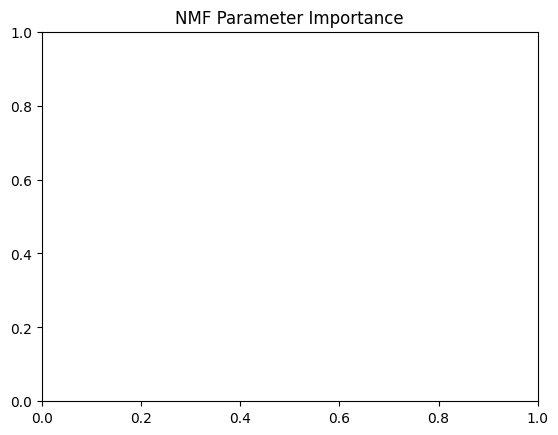

In [ ]:
import optuna
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np

# Prepare NMF data
nmf_tokens = tokenization_methods["simple_tokenization"]
nmf_docs = [' '.join(doc) for doc in nmf_tokens]
nmf_texts = [doc.split() for doc in nmf_docs]
nmf_id2word = Dictionary(nmf_tokens)
nmf_id2word.filter_extremes(no_below=3, no_above=0.9)

# Prepare the bow matrix
X_bow = vectorizers["bow"].fit_transform(nmf_docs)
bow_feature_names = vectorizers["bow"].get_feature_names_out()

# Enhanced objective function for Optuna
def nmf_objective(trial):
    # Try different initialization methods
    init = trial.suggest_categorical("init", ["nndsvd", "nndsvda", "nndsvdar", "random"])
    
    # Wider range for iterations
    max_iter = trial.suggest_int("max_iter", 300, 1000, step=100)
    
    # Try different solver options
    solver = trial.suggest_categorical("solver", ["cd", "mu"])
    
    # Beta loss options (only relevant for 'mu' solver)
    beta_loss = "frobenius"
    if solver == "mu":
        beta_loss = trial.suggest_categorical("beta_loss", ["frobenius", "kullback-leibler"])
    
    # More granular search for regularization parameters
    alpha_W = trial.suggest_float("alpha_W", 0.0, 2.0, step=0.2)
    alpha_H = trial.suggest_float("alpha_H", 0.0, 2.0, step=0.2)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.1)
    
    # Try different convergence tolerance
    tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)
    
    # Try multiple seeds to reduce variability and ensure stable results
    seeds = [42, 123, 456]
    coherence_scores = []
    
    for seed in seeds:
        try:
            nmf_model = NMF(
                n_components=7,
                init=init,
                solver=solver,
                beta_loss=beta_loss,
                max_iter=max_iter,
                alpha_W=alpha_W,
                alpha_H=alpha_H,
                l1_ratio=l1_ratio,
                tol=tol,
                random_state=seed
            )
            
            # Fit the model
            nmf_model.fit_transform(X_bow)
            
            # Extract topics
            topics = [[bow_feature_names[i] for i in topic.argsort()[:-11:-1]] 
                      for topic in nmf_model.components_]
            
            # Calculate coherence
            cm = CoherenceModel(
                topics=topics,
                texts=nmf_texts,
                dictionary=nmf_id2word,
                coherence='c_v'
            )
            coherence_scores.append(cm.get_coherence())
        except Exception as e:
            # Return a low score if any errors occur
            print(f"Error with parameters {trial.params}: {e}")
            return 0.0
    
    # Return mean coherence across seeds
    mean_coherence = np.mean(coherence_scores)
    return mean_coherence

# Create study with more sophisticated search
study_nmf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Use TPE sampler for better search
)

# Run more trials
study_nmf.optimize(nmf_objective, n_trials=40)

print("Best NMF Parameters:", study_nmf.best_trial.params)
print("Best NMF Coherence Score:", study_nmf.best_trial.value)



Compare NMF with default parameters vs best tuned parameters

In [17]:
# BoW + Default Parameters
nmf_bow = NMF(
    n_components=7, 
    init="random",
    alpha_W=0.0,
    alpha_H=0.0,
    l1_ratio=0.0,
    random_state=42, 
    max_iter=500)
H_bow = nmf_bow.fit_transform(X_bow)
topics_bow = [[bow_feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_bow.components_]

coherence_bow = CoherenceModel(
    topics=topics_bow, texts=nmf_texts, dictionary=nmf_id2word, coherence="c_v"
).get_coherence()

# BoW + Tuned Parameters 
params = study_nmf.best_trial.params

# Create the tuned NMF model with all best parameters
nmf_tuned = NMF(
    n_components=7,
    init=params.get("init", "nndsvd"),
    solver=params.get("solver", "cd"),
    beta_loss=params.get("beta_loss", "frobenius"),
    max_iter=params.get("max_iter", 500),
    alpha_W=params.get("alpha_W", 0.0),
    alpha_H=params.get("alpha_H", 0.0),
    l1_ratio=params.get("l1_ratio", 0.0),
    tol=params.get("tol", 1e-4),
    random_state=42
)
H_tuned = nmf_tuned.fit_transform(X_bow)
topics_tuned = [[bow_feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_tuned.components_]

coherence_tuned = CoherenceModel(
    topics=topics_tuned, texts=nmf_texts, dictionary=nmf_id2word, coherence="c_v"
).get_coherence()

# === Compile comprehensive results ===
df_nmf_ablation = pd.DataFrame({
    "Model": ["NMF (BoW + Default)", "NMF (BoW + Tuned)"],
    "Init": ["random", params.get("init")],
    "Solver": ["cd", params.get("solver", "cd")],
    "Max Iter": [500, params.get("max_iter")],
    "Alpha_W": [0.0, params.get("alpha_W")],
    "Alpha_H": [0.0, params.get("alpha_H")],
    "L1 Ratio": [0.0, params.get("l1_ratio")],
    "Tol": [1e-4, params.get("tol", 1e-4)],
    "Coherence Score": [coherence_bow, coherence_tuned]
})

print("\nComparison of Default vs Tuned NMF Models:")
print(df_nmf_ablation)

# Calculate percent improvement
if coherence_bow > 0:
    improvement = ((coherence_tuned - coherence_bow) / coherence_bow) * 100
    print(f"\nTuned model shows {improvement:.2f}% improvement in coherence score")

# Print topics from the better model
best_model_name = "Default NMF" if coherence_bow >= coherence_tuned else "Tuned NMF"
best_topics = topics_bow if coherence_bow >= coherence_tuned else topics_tuned
print(f"\nTop words from the best model ({best_model_name}):")
for i, topic in enumerate(best_topics):
    print(f"Topic {i+1}: {', '.join(topic)}")


Comparison of Default vs Tuned NMF Models:
                 Model      Init Solver  Max Iter  Alpha_W  Alpha_H  L1 Ratio  \
0  NMF (BoW + Default)    random     cd       500      0.0      0.0       0.0   
1    NMF (BoW + Tuned)  nndsvdar     mu       300      0.0      1.6       1.0   

        Tol  Coherence Score  
0  0.000100         0.645401  
1  0.000107         0.652104  

Tuned model shows 1.04% improvement in coherence score

Top words from the best model (Tuned NMF):
Topic 1: driver, rating, penumpang, pick, time, gocar, cancel, customer, gojek, booking
Topic 2: gojek, plus, akun, pakai, pake, grab, gopay, promo, langganan, kecewa
Topic 3: app, time, service, customer, use, good, bad, dont, food, need
Topic 4: order, cancel, food, time, gocar, hour, restaurant, waiting, cancelled, delivery
Topic 5: yg, titik, sesuai, promo, krn, dgn, ambil, tp, klo, tdk
Topic 6: aplikasi, gopay, pakai, sebelah, saldo, masuk, error, alamat, sesuai, hp
Topic 7: gofood, cancel, jam, nunggu, bange

Based on the Ablation Study, tuning the hyperparameters of LDA led to an improvement in coherence score, indicating better topic separation and interpretability. The best-performing model used alpha='auto', eta='symmetric', and passes=20, achieving a coherence score of 0.630374. 

### c. Interpret and label discovered topics based on word distribution





In [18]:
print("Top topics from NMF (BoW + Tuned):")
for i, topic in enumerate(topics_tuned):
    print(f"Topic {i+1}: {' + '.join(topic)}")

Top topics from NMF (BoW + Tuned):
Topic 1: driver + rating + penumpang + pick + time + gocar + cancel + customer + gojek + booking
Topic 2: gojek + plus + akun + pakai + pake + grab + gopay + promo + langganan + kecewa
Topic 3: app + time + service + customer + use + good + bad + dont + food + need
Topic 4: order + cancel + food + time + gocar + hour + restaurant + waiting + cancelled + delivery
Topic 5: yg + titik + sesuai + promo + krn + dgn + ambil + tp + klo + tdk
Topic 6: aplikasi + gopay + pakai + sebelah + saldo + masuk + error + alamat + sesuai + hp
Topic 7: gofood + cancel + jam + nunggu + banget + customer + pesanan + resto + kalo + makanan


Topic 0: Payment & Quick Service
- Keywords: "ok", "fast", "gopaylater", "semoga", "simple", "sopan", "review", "butuh", "server", "deket"

Topic 1: General App Satisfaction
- Keywords: "app", "good", "service", "apps", "time", "easy", "great", "use", "food", "always"

Topic 2: Positive Slang & Praise
- Keywords: "mantap", "meow", "banyakin", "mantab", "brainrot", "cakep", "aura", "gacor", "joss", "jos"

Topic 3: Service Frustrations 
- Keywords: "driver", "gojek", "aplikasi", "cancel", "gofood", "banget", "promo", "membantu", "susah", "gocar"

Topic 4: Emotional Reactions & Mixed Sentiment
- Keywords: "puas", "dark", "dibutuhkan", "makasih", "favorite", "foodnya", "asik", "ngawur", "excelent", "duitnya"

## 4. Evaluate topic modelling results



Model Evaluation (NMF BoW Tuned):
---------------------------
Coherence Score (c_v): 0.6521
Coherence Score (UCI): -0.4209
Coherence Score (NPMI): 0.0502

Coherence Scores per Topic:
Topic 0: 0.5479
Topic 1: 0.6392
Topic 2: 0.7174
Topic 3: 0.7325
Topic 4: 0.7068
Topic 5: 0.4769
Topic 6: 0.7440


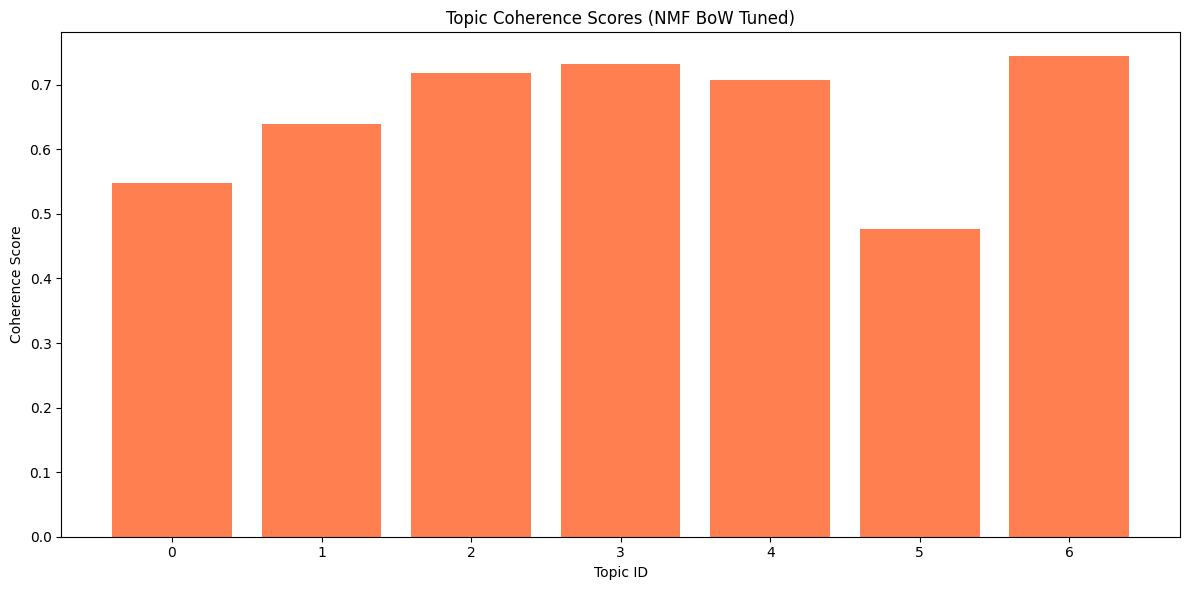


Topic Interpretation (NMF BoW Tuned):
-------------------------------
Topic #0: driver, rating, penumpang, pick, time, gocar, cancel, customer, gojek, booking
Topic #1: gojek, plus, akun, pakai, pake, grab, gopay, promo, langganan, kecewa
Topic #2: app, time, service, customer, use, good, bad, dont, food, need
Topic #3: order, cancel, food, time, gocar, hour, restaurant, waiting, cancelled, delivery
Topic #4: yg, titik, sesuai, promo, krn, dgn, ambil, tp, klo, tdk
Topic #5: aplikasi, gopay, pakai, sebelah, saldo, masuk, error, alamat, sesuai, hp
Topic #6: gofood, cancel, jam, nunggu, banget, customer, pesanan, resto, kalo, makanan


In [21]:
# Coherence using c_v measure (most common)
coherence_model_cv = CoherenceModel(
    topics=topics_tuned,
    texts=nmf_texts,
    dictionary=nmf_id2word,
    coherence='c_v'
)
coherence_cv = coherence_model_cv.get_coherence()
coherence_scores = coherence_model_cv.get_coherence_per_topic()

# You can also try other coherence measures
# UCI
coherence_model_uci = CoherenceModel(
    topics=topics_tuned,
    texts=nmf_texts,
    dictionary=nmf_id2word,
    coherence='c_uci'
)
coherence_uci = coherence_model_uci.get_coherence()

# NPMI
coherence_model_npmi = CoherenceModel(
    topics=topics_tuned,
    texts=nmf_texts,
    dictionary=nmf_id2word,
    coherence='c_npmi'
)
coherence_npmi = coherence_model_npmi.get_coherence()

print("\nModel Evaluation (NMF BoW Tuned):")
print("---------------------------")
print(f"Coherence Score (c_v): {coherence_cv:.4f}")
print(f"Coherence Score (UCI): {coherence_uci:.4f}")
print(f"Coherence Score (NPMI): {coherence_npmi:.4f}")
print("\nCoherence Scores per Topic:")
for i, score in enumerate(coherence_scores):
    print(f"Topic {i}: {score:.4f}")

plt.figure(figsize=(12, 6))
plt.bar(range(len(coherence_scores)), coherence_scores, color='coral')
plt.xlabel('Topic ID')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores (NMF BoW Tuned)')
plt.xticks(range(len(coherence_scores)))
plt.tight_layout()
plt.show()

# === Topic Interpretation ===
print("\nTopic Interpretation (NMF BoW Tuned):")
print("-------------------------------")
for i, topic in enumerate(topics_tuned):
    print(f"Topic #{i}: {', '.join(topic)}")
    # manual interpretations here

## 5. Categorize review tags

/tmp/ipykernel_424086/2740615422.py:4: RuntimeWarning:

invalid value encountered in divide



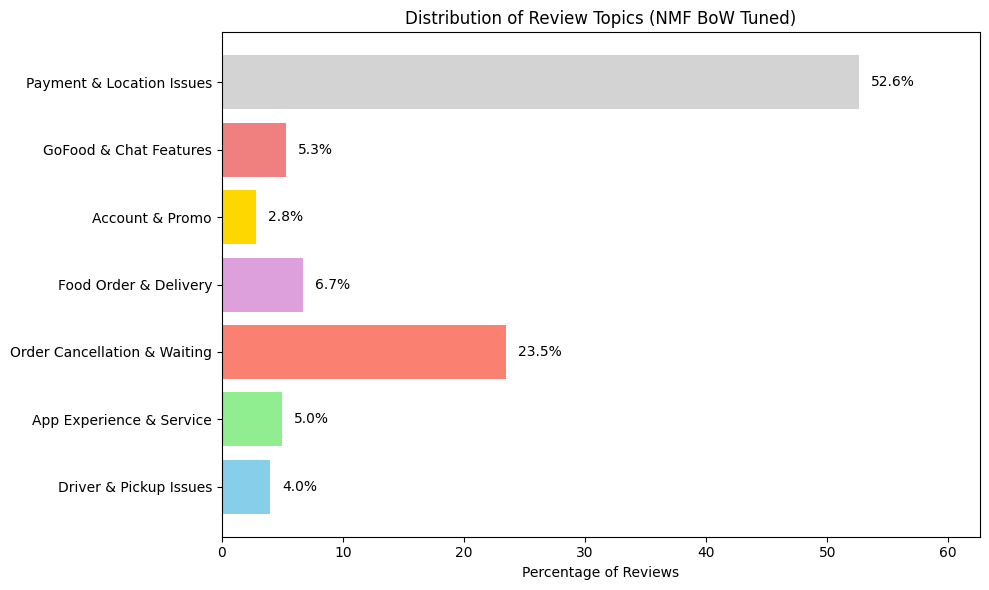

In [23]:
# Use nmf_tuned (from BoW + Tuned) for consistency
W = nmf_tuned.transform(X_bow)

W_normalized = W / W.sum(axis=1, keepdims=True)
W_normalized[np.isnan(W_normalized)] = 0  # handle any NaN from zero division

# Then average per topic
topic_proportions_nmf = W_normalized.mean(axis=0) * 100

# Define topic labels based on the tuned model topics
topic_labels = {
    0: "Driver & Pickup Issues",
    1: "App Experience & Service", 
    2: "Order Cancellation & Waiting",
    3: "Food Order & Delivery",
    4: "Account & Promo",
    5: "GoFood & Chat Features",
    6: "Payment & Location Issues"
}

# Make sure topic_names matches the number of topics (7)
topic_names_nmf = {
    0: topic_labels.get(0, "Topic 0"),
    1: topic_labels.get(1, "Topic 1"),
    2: topic_labels.get(2, "Topic 2"),
    3: topic_labels.get(3, "Topic 3"),
    4: topic_labels.get(4, "Topic 4"),
    5: topic_labels.get(5, "Topic 5"),
    6: topic_labels.get(6, "Topic 6")
}

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    [topic_names_nmf[i] for i in range(len(topic_proportions_nmf))],
    topic_proportions_nmf,
    color=['skyblue', 'lightgreen', 'salmon', 'plum', 'gold', 'lightcoral', 'lightgray']
)

for bar, value in zip(bars, topic_proportions_nmf):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{value:.1f}%", va='center', fontsize=10)

plt.xlabel('Percentage of Reviews')
plt.title('Distribution of Review Topics (NMF BoW Tuned)')
plt.xlim(0, max(topic_proportions_nmf) + 10)
plt.tight_layout()
plt.show()